# Etapa 1: Importação das bibliotecas

In [760]:
# Importing the necessary libraries:
import torch
from torch import nn, optim
import math
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler    # Biblioteca para transformar os dados a escala ente 0-1 
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error
import torch.nn.functional as F
torch.__version__
torch.manual_seed(123)

## Etapa 2: Base de dados

### Dado sintético


In [761]:
## Dado sintético 1 - organizado em serie temporal
data_length = 2049
zer=np.zeros((data_length,1))
for i in range(len(zer)): 
    zer[i] = 32 * math.pi*i/data_length
Dado_senoide = 4*np.sin(zer)

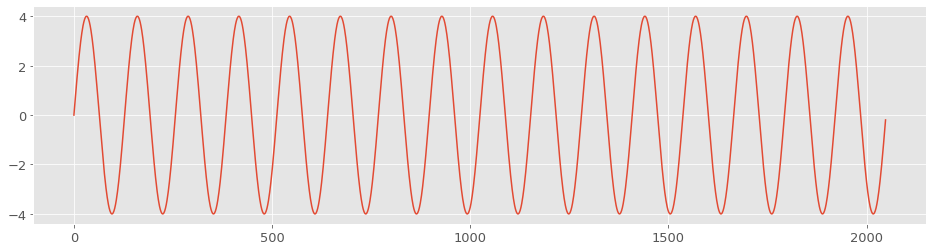

In [762]:
plt.plot(Dado_senoide)
#plt.plot(zer[:],Dado_senoide[0], ".")

In [763]:
#Dado_senoide

### >>> Dado real

####               >>>>           Dado ações da Petrobras

In [764]:
Dado_petr4 = pd.read_csv('../../DADOS/petr4_treinamento.csv')
## 3.1 apagando linhas NAN
Dado_petr4 = Dado_petr4.dropna()
Dado_petr4 = Dado_petr4.iloc[:, 1:2].values

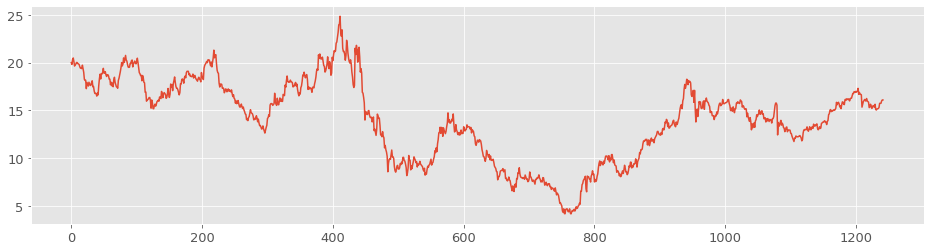

In [765]:
plt.plot(Dado_petr4)
#plt.plot(zer[:],Dado_senoide[0], ".")

#### >>>> Dado SOLAR

In [766]:
#Dt = pd.read_csv("/home/rodrigo/ENG_PRODUCAO/TCC/Redes-Neurais-Profundas_git_FELIPE/script/df_sem_outliers.csv",index_col=0,header=0, names=['solar_irradiation(w/m²)'])
Dt = pd.read_excel("../Resultados_iniciais/Serie_Dado_hour.xlsx",index_col=0,header=0, names=['Date_hour'])# Lendo o arquivo            
Dt.head()
## 3.1 apagando linhas NAN
Dt = Dt.dropna()
Dt=Dt[Dt["Date_hour"]>=1]
Dado_solar=Dt[["Date_hour"]].values
np.shape(Dado_solar)
#Dt.head()


(5038, 1)

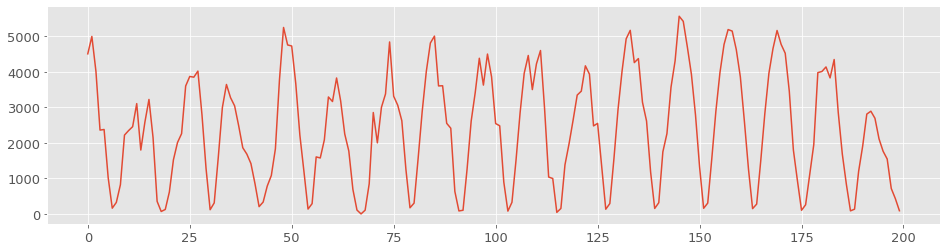

In [767]:
from pylab import rcParams
rcParams['figure.figsize'] = 16,4
plt.plot(Dado_solar[-200:])
#plt.plot(zer[:],Dado_senoide[0], ".")

## Etapa 3: Processando os dados

In [768]:
#base_treinamento = Dado_petr4

In [769]:
base_treinamento = Dado_solar

In [770]:
#base_treinamento = Dado_senoide

In [771]:
np.shape(base_treinamento)

(5038, 1)

## 3.1 apagando linhas NAN

base = base.dropna()
base.shape

## 3.2 Normalizando os dados entre 0-1

In [772]:
normalizador = MinMaxScaler(feature_range=(0,1))
base_treinamento_normalizada = normalizador.fit_transform(base_treinamento)
base_treinamento_normalizada

array([[0.03739247],
       [0.11167305],
       [0.35034289],
       ...,
       [0.09906269],
       [0.05971547],
       [0.01244743]])

## 3.3 Deslocando as lag da série pra obter X, e Y

In [773]:
lags=4 # Número de colunas x (valores do passado para prever o futuro)
input_dim=lags

X = []
y = []
for i in range(lags, len(base_treinamento_normalizada)):
    X.append(base_treinamento_normalizada[i-lags:i, 0])
    y.append(base_treinamento_normalizada[i, 0])
X, y = np.array(X), np.array(y)
np.shape(X),np.shape(y)

((5034, 4), (5034,))

## 3.4 Convertendo os dados para tensores

In [774]:
X = torch.tensor(X, dtype=torch.float32)
y = torch.tensor(y, dtype=torch.float32)

## 3.5 Concatenando X com Y

In [775]:
dataset = torch.zeros((len(y), lags+1)) #- Concatenando x e 
dataset[:,-1] = y
dataset[:,0:lags] = X
np.shape(dataset)

torch.Size([5034, 5])

In [776]:
dataset

tensor([[0.0374, 0.1117, 0.3503, 0.6229, 0.4432],
        [0.1117, 0.3503, 0.6229, 0.4432, 0.3934],
        [0.3503, 0.6229, 0.4432, 0.3934, 0.3451],
        ...,
        [0.3724, 0.2923, 0.2440, 0.2139, 0.0991],
        [0.2923, 0.2440, 0.2139, 0.0991, 0.0597],
        [0.2440, 0.2139, 0.0991, 0.0597, 0.0124]])

## 3.6 Criando e inserindo labels 

## 3..6.7 Separando parte de treino e parte de teste

In [777]:
Percent_train=0.9
train_labels = torch.zeros(int(Percent_train*len(y)))
train_set = [(dataset[i], train_labels[i]) for i in range(int(Percent_train*len(y)))]

test_labels = torch.zeros(len(y)-int(Percent_train*len(y)))
test_set = dataset[int(Percent_train*len(y)):len(y),:]

np.shape(test_set)
#np.shape(train_set)

torch.Size([504, 5])

## 3.4 Definindo mini batch para os dados

In [778]:
batch_size=int(len(train_labels)/62)
train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size, shuffle=False)
batch_size

73

# Etapa 4: Criação do modelo - GAN

## 4.1 Implementando o discriminador


### 4.1.1 - Discriminador Deep Learning Densa

In [779]:
print(" O input representa o número de colunas do X+y para modelar o rótulo 0 ou 1")
print(" A primeira camada do modelo discriminador deve ser preenchida com input=",lags+1)


 O input representa o número de colunas do X+y para modelar o rótulo 0 ou 1
 A primeira camada do modelo discriminador deve ser preenchida com input= 5


In [780]:
class DiscriminatorD(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(5, 32),
            nn.ReLU(),
            nn.Dropout(0.03),
            nn.Linear(32, 32),
            nn.ReLU(),
            nn.Dropout(0.03),
            nn.Linear(32, 32),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(32, 1),
            nn.Sigmoid(),
        )
    def forward(self, x):
        output = self.model(x)
        return output

discriminator=DiscriminatorD()

### 4.1.2 -  Discriminador Deep Learning Densa - curso

In [781]:
print(" O input representa o número de colunas do X+y para modelar o rótulo 0 ou 1")
print(" A primeira camada do modelo discriminador deve ser preenchida com input=",lags+1)


 O input representa o número de colunas do X+y para modelar o rótulo 0 ou 1
 A primeira camada do modelo discriminador deve ser preenchida com input= 5


In [782]:
class DiscriminatorD2(nn.Module):
    def __init__(self):
        super().__init__()
        # 784 -> 128 -> 64 -> 32 -> 1
        self.dense0 = nn.Linear(5, 128)
        self.dense1 = nn.Linear(128, 64)
        self.dense2 = nn.Linear(64, 32)
        self.dense3 = nn.Linear(32, 1)
        self.dropout = nn.Dropout(0.3)

    def forward(self, X):
        X = self.dropout(F.leaky_relu(self.dense0(X), 0.2))
        X = self.dropout(F.leaky_relu(self.dense1(X), 0.2))
        X = self.dropout(F.leaky_relu(self.dense2(X), 0.2))
        X = self.dense3(X)
        return X
D = DiscriminatorD2()

### 4.1.3 - Discriminador Deep RECORRENTE

## 4.2 Implementando o Gerador


### 4.2.1 - Gerador Deep Learning Densa

In [783]:
print(" O input representa o número de colunas do X para modelar 1 amostra y")
print(" A primeira camada do modelo gerador deve ser preenchida com input=",lags)


 O input representa o número de colunas do X para modelar 1 amostra y
 A primeira camada do modelo gerador deve ser preenchida com input= 4


In [784]:
class GeneratorD(nn.Module):

    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(4, 32),
            nn.ReLU(),
            nn.Linear(32, 32),
            nn.ReLU(),
            nn.Linear(32, 32),
            nn.ReLU(),
            nn.Linear(32, 32),
            nn.ReLU(),
            nn.Linear(32, 32),
            nn.ReLU(),
            nn.Linear(32, 16),
            nn.ReLU(),
            nn.Linear(16, 8),
            nn.ReLU(),
            nn.Linear(8, 1),
        )

    def forward(self, x):
        output = self.model(x)
        return output
generator = GeneratorD()

### 4.2.2 -  Gerador Deep Learning Densa - curso

In [785]:
print(" O input representa o número de colunas do X para modelar 1 amostra y")
print(" A primeira camada do modelo gerador deve ser preenchida com input=",lags)

 O input representa o número de colunas do X para modelar 1 amostra y
 A primeira camada do modelo gerador deve ser preenchida com input= 4


In [786]:
class GeneratorD2(nn.Module):
    def __init__(self):
        super().__init__()
        # 100 -> 32 -> 64 -> 128 -> 784
        self.dense0 = nn.Linear(4, 32)
        self.dense1 = nn.Linear(32, 64)
        self.dense2 = nn.Linear(64, 128)
        self.dense22 = nn.Linear(128, 128)
        self.dense3 = nn.Linear(128, 1)
        self.dropout = nn.Dropout(0.3)

    def forward(self, X):
        X = self.dropout(F.leaky_relu(self.dense0(X), 0.2))
        X = self.dropout(F.leaky_relu(self.dense1(X), 0.2))
        X = self.dropout(F.leaky_relu(self.dense2(X), 0.2))
        X = self.dropout(F.leaky_relu(self.dense22(X), 0.2))        
        X = self.dropout(F.leaky_relu(self.dense22(X), 0.2))                
        X = torch.tanh(self.dense3(X))
        #X = X.view(X.shape[0], 28, 28)
        return X
G = GeneratorD2()

### 4.2.3 - Gerador Deep RECORRENTE

## 4.3 Inicializando as peças

### 4.3.1 Definindo as peças

#### 4.3.1.1 Definindo as rede Gerador Discriminador 

In [787]:
discriminator=DiscriminatorD()
generator = GeneratorD()

#### 4.3.1.2 - Definindo os parâmetros do modelo

##### 4.3.1.2.1 - Pelo site

In [788]:
lr = 1e-3
lrD = 1e-3
lrG = 1e-3
num_epochs = 1000

loss_functionD = nn.BCELoss()
loss_functionG = nn.MSELoss()

criterion = nn.BCEWithLogitsLoss()

##### 4.3.1.2.2 - Pelo curso

#### 4.3.1.2 - Iinicializando os modelos

In [789]:
#SITE
optimizer_discriminator = torch.optim.Adam(discriminator.parameters(), lr=lr)
optimizer_generator = torch.optim.Adam(generator.parameters(), lr=lr)

In [790]:
# CURSO
G_optimizer = optim.Adam(G.parameters(), lr=lrG)
D_optimizer = optim.Adam(D.parameters(), lr=lrD)

In [791]:
device = torch.device('cuda') if torch.cuda.is_available else torch.device('cpu')
device
#device=torch.device('cpu'

device(type='cuda')

In [792]:
G.to(device)

GeneratorD2(
  (dense0): Linear(in_features=4, out_features=32, bias=True)
  (dense1): Linear(in_features=32, out_features=64, bias=True)
  (dense2): Linear(in_features=64, out_features=128, bias=True)
  (dense22): Linear(in_features=128, out_features=128, bias=True)
  (dense3): Linear(in_features=128, out_features=1, bias=True)
  (dropout): Dropout(p=0.3, inplace=False)
)

In [793]:
D.to(device)

DiscriminatorD2(
  (dense0): Linear(in_features=5, out_features=128, bias=True)
  (dense1): Linear(in_features=128, out_features=64, bias=True)
  (dense2): Linear(in_features=64, out_features=32, bias=True)
  (dense3): Linear(in_features=32, out_features=1, bias=True)
  (dropout): Dropout(p=0.3, inplace=False)
)

# 5 Treinamento do Modelo

## 5.1 Treinamento do Modelo Versão 1

### Crinado variável para acumular função erros ao longo das épocas.

In [794]:
import numpy as np
history_lossG = []
np.shape(history_lossG)

(0,)

## 5.1.2 LOOP DE TREINAMENTO - site

In [795]:
%time
num_epochs=-2000
for epoch in range(num_epochs):
    running_loss = 0.
    running_mae = 0.
    for n, (XYreal, _) in enumerate(train_loader):

# Montando dado para o discriminador - Vetor com 2*batchsize amostras. Metade y REAL metade y FAKE
        XYreal_labels = torch.ones((len(XYreal), 1))          # Gerando rotulos  real
        XYfake_abels = torch.zeros((len(XYreal), 1))          # Gerando rotulos fake
    
        Xreal = XYreal[:,0:lags].reshape(len(XYreal),lags)    # Pegando o x real
        Yfake = generator(Xreal)                              # modelando y fake com o x 

        XYfake=torch.zeros((len(XYreal), lags+1))             # Criando tensor para juntar x com y fake
        XYfake[:,-1] = Yfake[:,0]                             # Preenchendo a última coluna com y fake
        XYfake[:,0:lags] = Xreal                              # Preenchendo as colunas x real 
        
        all_samples = torch.cat((XYreal, XYfake))             # Concatenado x,y  REAL com x,y FAKE
        all_samples_labels = torch.cat((XYreal_labels, XYfake_abels)) # juntando rotulos

        # Training the discriminator
        discriminator.zero_grad()
        output_discriminator = discriminator(all_samples)
        loss_discriminator = loss_functionD(output_discriminator, all_samples_labels)
        loss_discriminator.backward()
        optimizer_discriminator.step()
        ########## Pronto, discriminador treinado   ########## 
        
# Montando dado para o discriminador - Vetor com 2*batchsize amostras. Metade y REAL metade y FAKE
        Xreal = XYreal[:,0:lags].reshape(len(XYreal),lags)    # Pegando o x real
        generator.zero_grad()                                 # Zerando o gradiente
        Yfake = generator(Xreal)                              # modelando y fake com o x 
        
        XYfake=torch.zeros((len(XYreal), lags+1))             # Criando tensor para juntar x com y fake
        XYfake[:,-1] = Yfake[:,0]                             # Preenchendo a última coluna com y fake
        XYfake[:,0:lags] = Xreal                              # Preenchendo as colunas x real 
        
        output_discriminator_generated = discriminator(XYfake) # Gerando rótulos com o discriminador
        # Avaliando os erros do discriminador
        loss_generator_discriminador = loss_functionG(output_discriminator_generated, XYreal_labels)
        # Atualizando o gerador com os erros do discriminador.
        loss_generator_discriminador.backward()
        optimizer_generator.step()

        
# Para Verbose ######################################################################################
# Para Verbose ######################################################################################
# Para Verbose ######################################################################################
        Yreal = torch.ones((len(XYreal), 1))
        Yreal[:,0] = XYreal[:,-1]

        loss_generator_discriminador = loss_functionG(Yfake, Yreal)
        
        running_loss += loss_generator_discriminador.item()        
        mae = mean_absolute_error(XYreal_labels.detach().cpu().numpy().flatten(), 
                                  output_discriminator_generated.detach().cpu().numpy().flatten())
        running_mae += mae


    running_loss /= len(XYreal)
    running_mae /= len(XYreal)
    print('ÉPOCA {:3d} FINALIZADA: custo {:03.6f} - MAE {:03.6f}     '.format(epoch+1, running_loss, running_mae))
    
    history_lossG.append(running_loss)


CPU times: user 10 µs, sys: 0 ns, total: 10 µs
Wall time: 19.1 µs


from pylab import rcParams
rcParams['figure.figsize'] = 10,3
yYreal=dataset[-250:,-1] 
xXreal=dataset[-250:,0:lags]

plt.plot(generator(xXreal).detach(), '-')
plt.plot(yYreal.detach(), '-')
np.shape(yYreal)


## 5.1.3 LOOP DE TREINAMENTO - curso

In [796]:
torch.manual_seed(101)
num_epochs=1000
for epoch in range(num_epochs):
    D_running_loss = 0
    G_running_loss = 0
    
    for i, (XYreal, _) in enumerate(train_loader):
        batch_size = XYreal.size(0)           # Tamanho da batch = Quantidade de amostras por batch
        XYreal = XYreal * 2 - 1               # Convertendo a base de dados para (-1,1) pq F.Tanh é nesse range
        XYreal = XYreal.to(device)            # Mandando a imagem para GPU
        
#######################################################################################
# Treinamento do gerador
#--------------------------------------------------------------------------------------
        G_optimizer.zero_grad()        
        Xreal = XYreal[:,0:lags].reshape(len(XYreal),lags)     # Pegando o x real
        Xreal = Xreal.to(device)                               # Mandando a imagem para GPU
        Yfake = G.forward(Xreal)                               # modelando y fake com o x 

        XYfake=torch.zeros((len(XYreal), lags+1))              # Criando tensor para juntar x com y fake
        XYfake[:,-1] = Yfake[:,0]                              # Preenchendo a última coluna com y fake
        XYfake[:,0:lags] = Xreal                               # Preenchendo as colunas x real 
        XYfake = XYfake.to(device)                             # Mandando a imagem para GPU
          
        outputs_XYfake = D.forward(XYfake)                     # Aqui passamos as imagens geradas para o descridador dizer qual a 
        labels_XYfake  = torch.ones(len(XYreal), 1) .to(device)    # Aqui calculamos o rótulo da imagem falsa.
        G_loss = criterion(outputs_XYfake, labels_XYfake)      # Aqui calculamos o contrerro do descriminador que é usado como erro do gerador.
    
        G_loss.backward()                                      # Inicialização do Backpropagation
        G_optimizer.step()                                     # Atualização dos pesos.
        
#######################################################################################
# Treinamento do discriminador
#--------------------------------------------------------------------------------------
        # Trabalhando com os dados reais
        D_optimizer.zero_grad()                             
        outputs_XYreal = D.forward(XYreal)                          # Modelagem do discriminador para os dados reais - esperado que seja 1
        labels_XYreal  = (torch.ones(len(XYreal), 1)*0.9).to(device)   # Aqui calculamos o rótulo da imagem falsa.  # Coletandos labels reais e aplicando um suavizaor (um ruidinho) - ajuda a generalizar
        D_loss_reais   = criterion(outputs_XYreal, labels_XYreal)   # Calculo do loss do Discriminador dado real
        
        # Trabalhando com os dados fake
        Yfake = G.forward(Xreal)                                 # modelando y fake com o x 
        XYfake=torch.zeros((len(XYreal), lags+1))                # Criando tensor para juntar x com y fake
        XYfake[:,-1] = Yfake[:,0]                                # Preenchendo a última coluna com y fake
        XYfake[:,0:lags] = Xreal                                 # Preenchendo as colunas x real 
        XYfake = XYfake.to(device)                               # Mandando a imagem para GPU        

        outputs_XYfake = D.forward(XYfake)                       # Modelagem do discriminador para os dados reais - esperado que seja 0
        labels_XYfake = torch.zeros(len(XYreal), 1).to(device)   # Gerando rótulos das imagens fake  
        D_loss_falsas = criterion(outputs_XYfake, labels_XYfake) # Calculo do loss do discriminador dado fake

        D_loss = D_loss_reais + D_loss_falsas                      # Para cada par real + fake somamos os erros cometidos
        D_loss.backward()                                          # Passamos esse erro para o Backpropagation
        D_optimizer.step()                                         # Atualizamos o modelo

        D_running_loss += D_loss.item()                            # Calculo do err para print
        G_running_loss += G_loss.item()                            # Calculo do err para print

        # Imprimindo os dados referentes a esse batch   
#        print('\rÉpoca {:03d} - Loop {:3d} de {:3d}: custo discriminador {:03.5f} - custo gerador {:03.5f}'.format(epoch + 1, i + 1, len(train_loader), D_loss.item(), G_loss.item()), end = '\r')
  
    # Imprimindo os dados referentes a essa época
#    D_running_loss /= len(train_loader)
#    G_running_loss /= len(train_loader)
#    print('ÉPOCA {:03d} finalizada: custo discriminador {:03.6f} - custo gerador {:03.6f}      '.format(epoch + 1, D_running_loss, G_running_loss))


In [797]:
G.eval()

GeneratorD2(
  (dense0): Linear(in_features=4, out_features=32, bias=True)
  (dense1): Linear(in_features=32, out_features=64, bias=True)
  (dense2): Linear(in_features=64, out_features=128, bias=True)
  (dense22): Linear(in_features=128, out_features=128, bias=True)
  (dense3): Linear(in_features=128, out_features=1, bias=True)
  (dropout): Dropout(p=0.3, inplace=False)
)

torch.Size([250])

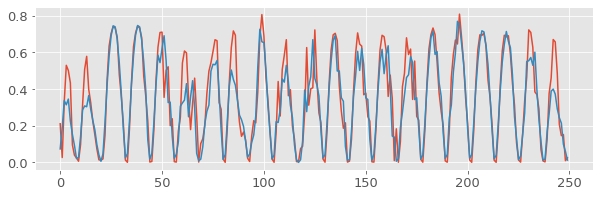

In [798]:
from pylab import rcParams
rcParams['figure.figsize'] = 10,3
yYreal=dataset[-250:,-1] 
xXreal=dataset[-250:,0:lags]*2-1
xXreal=xXreal.to(device)
plt.plot((G.forward(xXreal).cpu().detach().numpy()+1)/2, '-')
plt.plot(yYreal.detach(), '-')
np.shape(yYreal)


0.07513123

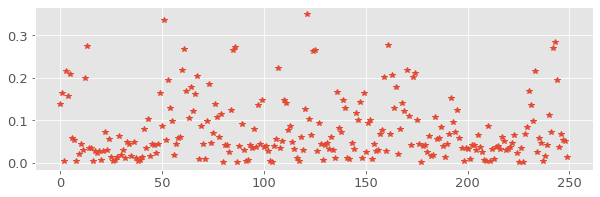

In [799]:
from pylab import rcParams
rcParams['figure.figsize'] = 10,3
yYreal=dataset[-250:,-1] 
xXreal=dataset[-250:,0:lags]*2-1
xXreal=xXreal.to(device)
erro=(((G.forward(xXreal).cpu().detach().numpy()+1)/2))-((yYreal.detach().numpy().reshape(len(yYreal),1)))
plt.plot(abs(erro), '*')
abs(erro).mean()

# 6 Avaliação do modelo

## Bibliotecas necessárias - Felipe

In [800]:
class TrataHora():
    #Converte os dados de minutos para horas e separa de acordo com os períodos de maior irradiação
    
    def __init__(self,dados):
        # Inicializa o atributo para o tratamento
        self.dados = dados
        
    def separa_horas(self):
        # Separa os 6 registros em minutos de cada hora num array (ex.: 00:10 até 01:00...)
        return [self.dados[i*6:(i+1)*6] for i in range(int(len(self.dados)/6))]

    def horas_uteis(self):
        # Seleciona o intervalo horário de 8-16 dentro de todos os dias do conjunto
        return np.concatenate([self.separa_horas()[(j*24):24+(j*24)] for j in range(int(len(self.separa_horas())/24))])
    
    def media(self):
        # Realiza a média horária dos dados
        var = self.horas_uteis()
        data = []
        for k in range(len(var)):
            data.append(np.mean(var[k]))
        return data

## 6.1 Trabalhando com dados de VALIDAÇÃO - Teste

In [801]:
XV = test_set[:,:-1]#.reshape(len(XYreal),lags) 
yV = test_set[:,-1]
np.shape(XV),np.shape(yV)

(torch.Size([504, 4]), torch.Size([504]))

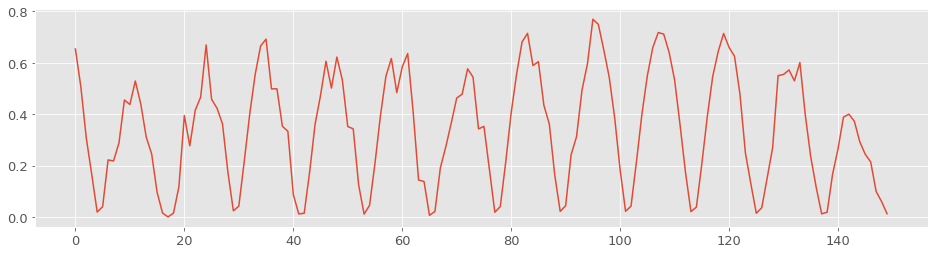

In [802]:
from pylab import rcParams
rcParams['figure.figsize'] = 16,4
plt.plot(yV[-150:])

## 6.5 Previsão

In [803]:
yV1=yV[-75:-21] 
XV1=XV[-75:-21,:]*2-1
XV1=XV1.to(device)
previsto=(((G.forward(XV1).cpu().detach().numpy()+1)/2))

## 6.6 Normalização inversa

In [804]:
Yprevisto=normalizador.inverse_transform(previsto)
Yreal=normalizador.inverse_transform(((yV1.detach().numpy().reshape(len(yV1),1))))

## 6.7 Avaliação dos resultados

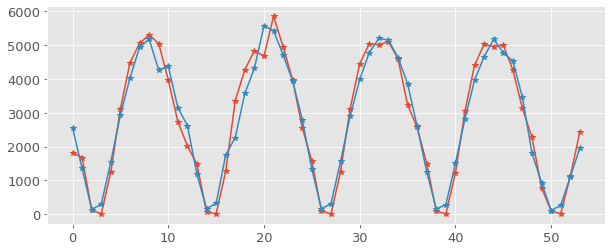

In [805]:
from pylab import rcParams
rcParams['figure.figsize'] = 10,4
#yV1=yV[-55:] 
#XV1=XV[-55:,:]*2-1
#XV1=XV1.to(device)
plt.plot(Yprevisto, '-*')
plt.plot(Yreal, '-*')

### 6.7.2 - Ánalise do erro absoludo 

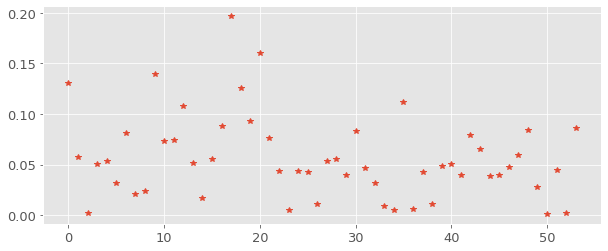

In [806]:
erro=Yprevisto-Yreal
plt.plot(abs(erro)/max(Yreal), '*')

### 6.7.2 - Calculo do erro absoludo médio

In [807]:
print("O modelo teve um erro absoluto médio de': %f%%" %  (((abs(erro)/max(abs(Yreal))).mean())*100) )

O modelo teve um erro absoluto médio de': 5.691682%


# 8 Reorganizando dados adicionando header

In [808]:
Teste1=Dt[int(Percent_train*len(y)):len(y)]
Teste2=Dt[-len(Yprevisto):] 

### Adcicionando header nos dados 

In [809]:
interval=Teste2.index

predictions=pd.DataFrame(Yprevisto)
predictions['Date']=interval
predictions.set_index('Date', inplace=True)
predictions.columns=['fGAN']
#predictions.head()

Yreal_data=pd.DataFrame(Yreal)
Yreal_data['Date']=interval
Yreal_data.set_index('Date', inplace=True)
Yreal_data.columns=['Real']
#predictions.head()

concatenado_FAIXATESTE = pd.merge(predictions,Yreal_data, how = 'outer', on = 'Date')
concatenado_FAIXATESTE.columns=['fGAN','Real']

## Salvando os resultados

In [ ]:
concatenado_FAIXATESTE.to_excel("../Resultados_fGAN/resultados_binarios/Serie_Dado_real_plu_fGAN_hourly.xlsx")

## Plotando os resultados

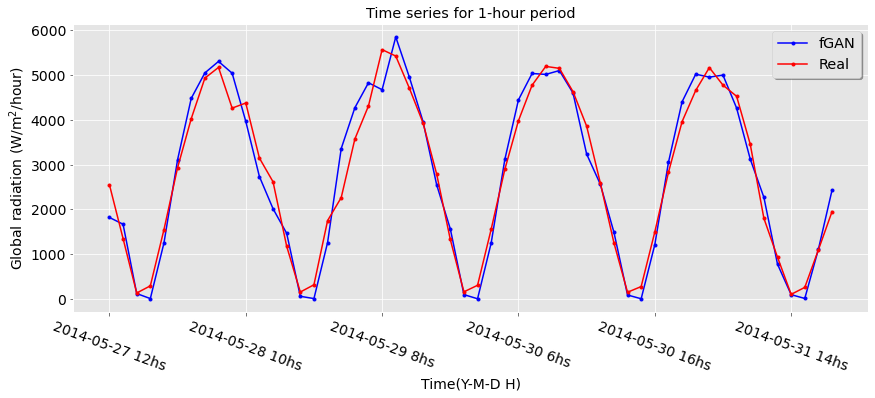

In [811]:
# Vamos plotar
########################################################################################
####          PLOTANDO OS RESULTADOS EM PDF
########################################################################################
#----------------------------------------------------------------------------------------------------------
# Vamos agora plotar tanto o modelo, a previsão e a série original.
import matplotlib 
matplotlib.rc('xtick', labelsize=13)  # Alterando a fonte 
matplotlib.rc('ytick', labelsize=13)  # Alterando a fonte 
plt.style.use('ggplot')
tick_spacing = 12

#----------------------------------------------------------------------------------------------------------
fig=plt.figure(figsize=(12,8))
ax=fig.add_axes([0.06, 0.12, 0.92, 0.5])
#---------------------------------------------------------------------------------------------------------
# Colocando toda a faixa de previsão e de modelagem
concatenado_FAIXATESTE['fGAN'].plot(ax=ax,marker='.', color='blue', legend=True, 
                                    title='Time series for 1-hour period', fontsize=14)
#----------------------------------------------------------------------------------------------------------
# Colocando só a faixa de previsão
concatenado_FAIXATESTE['Real'].plot(ax=ax,marker='.', color='red', fontsize=14, legend=True)

plt.xticks(rotation = -20, fontsize=14, color='black')
plt.yticks(fontsize=14, color='black')
#ax.xaxis.set_major_locator(ticker.MultipleLocator(tick_spacing))

ax.set_ylabel('Global radiation (W/m$^2/$hour)', fontsize=14, color='black')
ax.set_xlabel('Time(Y-M-D H)', fontsize=14, color='black')

legend = ax.legend(loc='upper right', shadow=True, fontsize='x-large')

#fig.tight_layout()
fig.savefig("../Resultados_fGAN/Result_fGAN_hour.png", bbox_inches='tight')

# Metricas

In [812]:
from sklearn import metrics
print('MAE:', metrics.mean_absolute_error(Yreal_data, predictions))
print('MSE:', metrics.mean_squared_error(Yreal_data, predictions))
print('RMSE:', np.sqrt(metrics.mean_squared_error(Yreal_data, predictions)))

MAE: 317.05606
MSE: 153268.0
RMSE: 391.49457


## Erro Percentual Absoluto Médio (MAPE)

Em contraste com as métricas anteriores, essa medida exprime uma porcentagem, obtida através da divisão da diferença entre predito (ŷ) e real pelo valor real (y)



In [813]:
import numpy as np
MAPE = np.mean(np.abs((Yreal - Yprevisto)/ ((max(Yreal)+Yreal)/2) )) * 100
print(f"Valor do MAPE dado em percentual: {MAPE}")

Valor do MAPE dado em percentual: 7.628707587718964


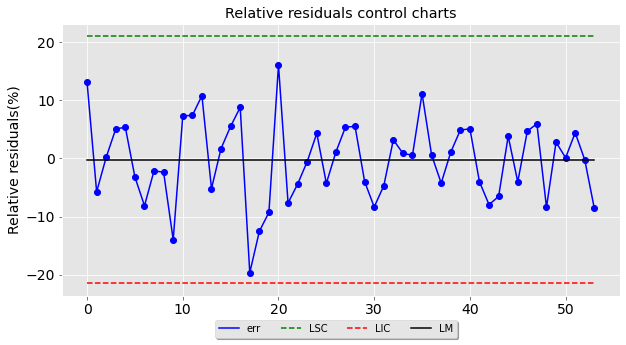

In [814]:
#def Carta_Controle1(predictions,test_Y2):
rcParams['figure.figsize'] = 10, 5
erro=pd.DataFrame
erro=(Yreal_data['Real']- predictions['fGAN'])#/max(Yreal_data['Real'])*100
#erro.to_csv("/home/rodrigo/Dropbox/Estudando_IA/PIBIC_UFBA/erro_previsao_RBF3.csv")
def Carta_Controle1(erro):
    barra_erro=erro.mean()
    desvio_erroc=erro.std()
    LSC=[]
    LIC=[]
    LM=[]
    i=0
    while i <len(erro):
        LIC.append(barra_erro-3*desvio_erroc)
        LSC.append(barra_erro+3*desvio_erroc)
        LM.append(barra_erro)
        i+=1
    erroV=erro.values.astype('float32')
    fig, ax = plt.subplots(1,1)
    plt.plot(erroV, 'bo')
    plt.plot(erroV, 'b', label='err')
    plt.plot(LSC, 'g--', label='LSC')
    plt.plot(LIC, 'r--', label='LIC')
    plt.plot(LM, 'black', label='LM')
    plt.title('Relative residuals control charts')
    plt.yticks(fontsize=14, color='black')
    plt.xticks(fontsize=14, color='black')   
    ax.set_ylabel('Relative residuals($\frac{W}{m^2}$)', fontsize=14, color='black')

    ax.legend(loc='upper left', bbox_to_anchor=(0.265, -0.07), shadow=True, ncol=4)
    fig.savefig('../Resultados_fGAN/Controle_chair_ERRO_hour.pdf', format='pdf')
Carta_Controle1(erro)

In [ ]:
#def Carta_Controle1(predictions,test_Y2):
rcParams['figure.figsize'] = 10, 5
erro=pd.DataFrame
erro=(Yreal_data['Real']- predictions['fGAN'])/(max(Yreal_data['Real'])+Yreal_data['Real'])*100

#erro.to_csv("/home/rodrigo/Dropbox/Estudando_IA/PIBIC_UFBA/erro_previsao_RBF3.csv")
def Carta_Controle1(erro):
    barra_erro=erro.mean()
    desvio_erroc=erro.std()
    LSC=[]
    LIC=[]
    LM=[]
    i=0
    while i <len(erro):
        LIC.append(barra_erro-3*desvio_erroc)
        LSC.append(barra_erro+3*desvio_erroc)
        LM.append(barra_erro)
        i+=1
    erroV=erro.values.astype('float32')
    fig, ax = plt.subplots(1,1)
    plt.plot(erroV, 'bo')
    plt.plot(erroV, 'b', label='err')
    plt.plot(LSC, 'g--', label='LSC')
    plt.plot(LIC, 'r--', label='LIC')
    plt.plot(LM, 'black', label='LM')
    plt.title('Relative residuals control charts')
    plt.yticks(fontsize=14, color='black')
    plt.xticks(fontsize=14, color='black')   
    ax.set_ylabel('Relative residuals(%)', fontsize=14, color='black')

    ax.legend(loc='upper left', bbox_to_anchor=(0.265, -0.07), shadow=True, ncol=4)
    fig.savefig('../Resultados_fGAN/Controle_chair_ERRO_hour_percent.pdf', format='pdf')
Carta_Controle1(erro)

#### 